# Common Imports

In [1]:
import os
import re
import pandas as pd
import numpy as np
import scipy
import sklearn
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Imports

In [2]:
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV, VarianceThreshold
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve, cross_validate
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize, Normalizer, MaxAbsScaler
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score, explained_variance_score, make_scorer
from sklearn.ensemble import AdaBoostRegressor, IsolationForest
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor, LocalOutlierFactor
from sklearn.naive_bayes import ComplementNB, MultinomialNB, GaussianNB
from sklearn.neural_network import MLPRegressor

Using TensorFlow backend.


# Set The Visual Style

In [3]:
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
from IPython.display import display, HTML
%matplotlib inline
sns.set(style='dark')
plt.rcParams['figure.figsize'] = [14, 10]

# Set Hyperparameters

In [4]:
new_apt_sample_size = 1
metrics = ['neg_mean_absolute_error', 'neg_median_absolute_error', 'r2', 'explained_variance', 'max_error']
cv = 3
random_seed = 42
var_threshold = 0.3
test_size = 0.3
preferred_score = 'r2'
tensorflow.set_random_seed(random_seed)

# Import Data
## Main Dataset

In [5]:
query_dir = 'queries'

In [6]:
queries = {}
for query_file in (os.listdir(query_dir)):
    with open(os.path.join(query_dir, query_file), 'r') as query:
        queries[query_file] = query.read()

In [7]:
query_client = bigquery.Client()

In [8]:
request = queries['combined_analysis_data.sql']

In [9]:
data = query_client.query(request).to_dataframe()

In [10]:
data = data[(data.price.notna()) & (data.primary_size.notna())].copy()

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4847 entries, 0 to 5453
Data columns (total 22 columns):
ad_id                 4847 non-null int64
apt_id                3562 non-null object
new_building          4847 non-null bool
num_bedrooms          4776 non-null float64
floor                 4066 non-null float64
primary_size          4847 non-null float64
total_size            4739 non-null float64
price                 4847 non-null float64
property_type         4847 non-null object
ownership_type        4847 non-null object
construction_year     4842 non-null float64
energy_character      1657 non-null object
common_expenses       968 non-null float64
brokerage_expenses    1282 non-null float64
common_wealth         679 non-null float64
common_debt           1212 non-null float64
time_s                4674 non-null float64
lat                   4674 non-null float64
lng                   4674 non-null float64
address               4847 non-null object
short_description     484

## Google Maps Neighborhood Data

In [12]:
request = queries['all_post_code_places.sql']

In [13]:
gmaps_neighborhood_data = query_client.query(request).to_dataframe()

In [14]:
gmaps_neighborhood_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117498 entries, 0 to 117497
Data columns (total 6 columns):
post_code          117498 non-null object
radius             117498 non-null int64
place_name         117498 non-null object
place_type         117498 non-null object
place_attribute    117498 non-null object
attribute_value    42240 non-null float64
dtypes: float64(1), int64(1), object(4)
memory usage: 5.4+ MB


## Norwegian Post Code Data

In [15]:
request = queries['post_codes_osl.sql']
post_codes_osl = query_client.query(request).to_dataframe().set_index('post_code', drop=True)

In [16]:
request = queries['post_codes_no.sql']
post_codes_no = query_client.query(request).to_dataframe().set_index('post_code', drop=True)

In [17]:
request = queries['post_code_area_name.sql']
post_codes = query_client.query(request).to_dataframe().set_index('post_code', drop=True)

# Feature Engineering
## Energy Letter and Color

In [18]:
energy_cols = ['energy_letter', 'energy_color']

for col in energy_cols:
    data[col] = 0

energy_res = [[c.strip() for c in char.split('-')] if char is not None and '-' in char else [None, None] for char in data.energy_character]
data[energy_cols] = pd.DataFrame(energy_res, columns=energy_cols)

## Post Codes

In [19]:
def get_postcode_from_address(address):
    try:
        return re.search(r'(.*)(\d{4})(.*)', address, re.I)[2]
    except:
        return None

In [20]:
data['post_code'] = data.address.apply(get_postcode_from_address)

## Combined Area Names

In [21]:
data = data.merge(post_codes, how='left', left_on='post_code', right_index=True)

In [22]:
data['address_oslo'] = data['settlement_name'].apply(lambda s_n: True if s_n == 'oslo' else False)

## Price Per Square Meter

In [23]:
data['price_per_sq_m'] = data.price.div(data.primary_size).round(0)

In [24]:
new_building_pct = pd.Series(data[data.new_building == True]\
                             .groupby('area_name')['ad_id'].count()\
                             .div(data\
                                  .groupby('area_name')['ad_id'].count()),
                             name='area_new_building_pct')

data = data.merge(new_building_pct, how='left', left_on='area_name', right_index=True)

## Combined Property Type

In [25]:
data['comb_property_type'] = ['house' if pt in ['Enebolig', 'Rekkehus', 'Tomannsbolig']
                              else 'apartment' if pt == 'Leilighet'
                              else 'other'
                              for pt in data['property_type']]

## Median House Price Per Post Code

In [26]:
median_property_prices = pd.pivot_table(data=data[data.comb_property_type.isin(['house', 'apartment'])],
                                        index='post_code',
                                        columns='comb_property_type',
                                        values='price_per_sq_m',
                                        aggfunc='median')

median_property_prices.rename(columns={'apartment': 'med_price_apartment', 'house': 'med_price_house'}, inplace=True)

data = data.merge(median_property_prices, how='left', left_on='post_code', right_index=True)

# Data Imputation

In [27]:
data.isna().sum(axis=0).sort_values(ascending=False)[:20]

common_wealth            4168
common_expenses          3879
common_debt              3635
brokerage_expenses       3565
energy_color             3437
energy_letter            3437
energy_character         3190
med_price_house          1921
apt_id                   1285
floor                     781
med_price_apartment       179
lng                       173
lat                       173
time_s                    173
total_size                108
num_bedrooms               71
area_new_building_pct      67
construction_year           5
address                     0
property_type               0
dtype: int64

## Impute Number Of Bedrooms

In [28]:
data['primary_size_bin'] = pd.cut(data['primary_size'], bins=[-np.inf, 30, 40, 50, 60, 70, 80, 100, 150, 200, np.inf])

In [29]:
num_bedrooms_grouping = data.groupby(['primary_size_bin'])['num_bedrooms'].median()

In [30]:
data['num_bedrooms'] = [num_bedrooms_grouping.loc[size_bin] if np.isnan(num_bedr) else num_bedr
                        for size_bin, num_bedr
                        in zip(data['primary_size_bin'], data['num_bedrooms'])]

## Impute Floor

In [31]:
data['floor_level'] = [fl if prop_type == 'Leilighet' else 1 for fl, prop_type in zip(data['floor'], data['property_type'])]
data['num_floors'] = [fl if prop_type != 'Leilighet' else 1 for fl, prop_type in zip(data['floor'], data['property_type'])]

data['floor_level'] = data['floor_level'].fillna(1)
data['num_floors'] = data['num_floors'].fillna(1)
data['floor'] = data['floor'].fillna(2)

## Impute Total Size

In [32]:
data['total_size'] = [primary_size if np.isnan(total_size) else total_size
                      for primary_size, total_size
                      in zip(data['primary_size'], data['total_size'])]

## Impute Construction Year

In [33]:
data['construction_year'].fillna(data[data['new_building'] == False]['construction_year'].median(), inplace=True) 

## Impute Energy Character

In [34]:
constr_year_bins = [-np.inf, 1900, 1945, 1965, 1970, 1980, 1990, 2000, 2010, np.inf]
data['construction_year_bin'] = pd.cut(data['construction_year'],
                                       bins=constr_year_bins)

In [35]:
to_plot = data.groupby(['construction_year_bin', 'energy_letter'])['energy_letter'].count()

In [36]:
most_common_energy_c = []
constr_year_index = []
for y in to_plot.index.get_level_values('construction_year_bin').unique():
    most_common_energy_c.append(to_plot.loc[y].sort_values(ascending=False).index[0])
    constr_year_index.append(y)

In [37]:
energy_letter_grouping = pd.Series(most_common_energy_c, index=constr_year_index)

In [38]:
def imnpute_energy_letter(letter, construction_year_bin):
    if str(letter) in 'ABCDEFG':
        return letter
    else:
        return energy_letter_grouping.loc[construction_year_bin]

In [39]:
data['energy_letter'] = [imnpute_energy_letter(letter, construction_year_bin) for letter, construction_year_bin in zip(data['energy_letter'], data['construction_year_bin'])]

In [40]:
to_plot = data.groupby(['construction_year_bin', 'energy_color'])['energy_color'].count()

In [41]:
most_common_energy_c = []
constr_year_index = []
for y in to_plot.index.get_level_values('construction_year_bin').unique():
    most_common_energy_c.append(to_plot.loc[y].sort_values(ascending=False).index[0])
    constr_year_index.append(y)

In [42]:
energy_color_grouping = pd.Series(most_common_energy_c, index=constr_year_index)

In [43]:
def imnpute_energy_color(color, construction_year_bin):
    if str(color) in ['mørkegrønn', 'oransje', 'lysegrønn', 'rød', 'gul']:
        return color
    else:
        return energy_color_grouping.loc[construction_year_bin]

In [44]:
data['energy_color'] = [imnpute_energy_color(color, construction_year_bin) for color, construction_year_bin in zip(data['energy_color'], data['construction_year_bin'])]

## Impute Travel Time

In [45]:
missing_transport_factor = 1
data['time_s'].fillna(data['time_s'].max() * missing_transport_factor, inplace=True)

## Impute Median House Price

In [46]:
data['med_price_apartment'] = data.med_price_apartment.fillna(data.med_price_apartment.mean())
data['med_price_house'] = data.med_price_house.fillna(data.med_price_house.mean())

## Impute New Building Percentage

In [47]:
data['area_new_building_pct'] = data.area_new_building_pct.fillna(data.area_new_building_pct.mean())

# Google Maps Data

In [48]:
gmaps_neighborhood_data.head()

,post_code,radius,place_name,place_type,place_attribute,attribute_value
0,0001,500,Oslo,locality,rating,NaN
1,0001,500,Oslo,political,rating,NaN
2,0001,500,Oslo Opera House,premise,rating,NaN
3,0001,500,Oslo Opera House,point_of_interest,rating,NaN
4,0001,500,Oslo Opera House,establishment,rating,NaN


In [49]:
neighborhood_data = pd.DataFrame(index=gmaps_neighborhood_data.post_code.unique())

In [50]:
neighborhood_data['mean_post_code_rating'] = gmaps_neighborhood_data[(gmaps_neighborhood_data.place_attribute == 'rating')]\
                                             .groupby('place_name').first()\
                                             .groupby('post_code')['attribute_value'].mean()

In [51]:
neighborhood_data['post_code_place_count'] = gmaps_neighborhood_data[(gmaps_neighborhood_data.place_attribute == 'rating')]\
                                             .groupby('place_name').first()\
                                             .groupby('post_code')['attribute_value'].count()

In [52]:
to_plot = gmaps_neighborhood_data[gmaps_neighborhood_data.place_attribute == 'rating']
place_counts = pd.pivot_table(data=to_plot, index='post_code', columns='place_type', values='attribute_value', aggfunc='count', fill_value=0)

In [53]:
neighborhood_data = neighborhood_data.join(place_counts)

In [54]:
neighborhood_data.fillna(0, inplace=True)

In [55]:
data = data.merge(neighborhood_data, how='left', left_on='post_code', right_index=True)

In [56]:
neighborhood_cols = list(neighborhood_data.columns)

# National Health Institute Data

In [57]:
request = queries['full_fhi_data.sql']

In [58]:
fhi_data = query_client.query(request).to_dataframe()

In [59]:
fhi_data.head()

,dataset,area_name,year,value
0,income_inequality,hurdal,2013,0.023
1,income_inequality,st.hanshaugen,2013,0.038
2,income_inequality,frogner,2013,0.045
3,income_inequality,ullern,2013,0.039
4,income_inequality,vestre aker,2013,0.043


In [60]:
fhi_data_latest = pd.DataFrame(index=fhi_data.area_name.unique())
for dataset in fhi_data.dataset.unique():
    to_join = fhi_data[fhi_data.dataset == dataset]
    latest_year = to_join[to_join.value.notna()].year.max()
    to_join_latest_year = to_join[to_join.year == latest_year]
    to_join_pivot = pd.pivot_table(data=to_join_latest_year,
                                   index='area_name',
                                   values='value').rename(columns={'value': dataset})
    fhi_data_latest = fhi_data_latest.join(to_join_pivot)

In [61]:
fhi_data_latest.head()

,income_inequality,uni_graduates,low_income_households,cramped_spaces,immigrant_pct
hurdal,0.025,0.35,0.168,0.128,0.103
st.hanshaugen,0.038,0.73,0.186,0.469,0.278
frogner,0.047,0.72,0.160,0.328,0.280
ullern,0.040,0.76,0.066,0.160,0.199
vestre aker,0.045,0.77,0.069,0.140,0.178


In [62]:
fhi_cols = list(fhi_data_latest.columns)

In [63]:
data = data.merge(fhi_data_latest, how='left', left_on='area_name', right_index=True)

# Remove Properties Other Than Houses and Apartments

In [64]:
data = data[~data.property_type.isin(['Garasje/Parkering', 'Gårdsbruk/Småbruk'])].copy()

# Mark Selected Columns

In [65]:
num_cols = ['price_per_sq_m', 'price', 'primary_size', 'time_s', 'floor', 'num_bedrooms',
            'construction_year', 'area_new_building_pct', 'med_price_apartment', 'med_price_house'] + fhi_cols + neighborhood_cols
cat_cols = ['comb_property_type', 'ownership_type', 'address_oslo', 'new_building']
text_cols = ['full_description']

In [66]:
data_sample_from_new_buildings = data.groupby('ad_id').apply(lambda obj: obj.sample(n=new_apt_sample_size, random_state=random_seed)
                                                             if len(obj) > new_apt_sample_size
                                                             else obj.sample(len(obj)))

In [67]:
num_data = data_sample_from_new_buildings[num_cols].copy()

In [68]:
cat_data = data_sample_from_new_buildings[cat_cols].copy()

In [69]:
for col in cat_cols:
    cat_data = cat_data.join(pd.get_dummies(cat_data[col], prefix=col, drop_first=True))
    cat_data.drop(col, axis=1, inplace=True)

In [70]:
text_data = data_sample_from_new_buildings[text_cols].copy()

# Predict Price With Numeric And Categorical Features

In [71]:
def get_learning_curves(estimator, X, y, train_sizes=np.arange(0.1, 1.1, 0.1), score='neg_mean_absolute_error', cv=5):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, train_sizes=train_sizes, scoring=score, cv=cv)
    curve_data = pd.DataFrame(columns = range(train_scores.shape[1]))
    for result, result_type in zip([train_scores, test_scores], ['train', 'test']):
        frame = pd.DataFrame(result)
        frame['size'] = train_sizes
        frame['type'] = result_type
        curve_data = curve_data.append(frame, ignore_index = True)
    curve_data = curve_data.melt(id_vars = ['size', 'type'], var_name = 'cv_fit', value_name = 'score')
    return curve_data

In [72]:
def get_cv_res(estimator, X, y, score=['neg_mean_absolute_error'], cv=5):
    cross_val = cross_validate(estimator, X, y, scoring=score, cv=cv)
    return cross_val

In [73]:
def print_cv_res(cross_val):
    for key, val in cross_val.items():
        print('Mean {}, {:.2f}'.format(key, val.mean()))

In [74]:
def create_model():
    model = Sequential()
    model.add(Dense(32, input_dim=X_train.shape[1], activation="relu"))
    model.add(Dense(16, activation="relu"))
    # model.add(Dropout(0.25))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(4, activation="relu"))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [75]:
estimators = {'deep_learning_regressor': KerasRegressor(build_fn=create_model, epochs=700, batch_size=700, verbose=False),
              'adaboost': AdaBoostRegressor(random_state=random_seed),
              'linear': LinearRegression(),
              'kneighbors': KNeighborsRegressor(),
              'bayes': ComplementNB(),
              'mlp': MLPRegressor(random_state=random_seed)}

In [76]:
estimator = estimators['adaboost']

# Define Model Data
## Remove NaNs

In [77]:
model_data = num_data.join(cat_data)

In [78]:
model_data.isna().sum(axis=0).sort_values(ascending=False)[:20]

income_inequality        4
uni_graduates            4
low_income_households    4
cramped_spaces           4
immigrant_pct            4
hindu_temple             1
electronics_store        1
fire_station             1
finance                  1
establishment            1
embassy                  1
department_store         1
electrician              1
doctor                   1
food                     1
dentist                  1
courthouse               1
florist                  1
gas_station              1
funeral_home             1
dtype: int64

In [79]:
model_data.dropna(inplace=True)

## Select Properties In Oslo

In [80]:
model_data.shape

(1550, 126)

## Remove Low Variance Features

In [81]:
var_estimator = VarianceThreshold(threshold=var_threshold)

In [82]:
var_estimator.fit(model_data)

VarianceThreshold(threshold=0.3)

In [83]:
variances = pd.Series(var_estimator.variances_, index=model_data.columns)

In [84]:
variances.sort_values(ascending=False).head(30)

price                     1.605883e+13
price_per_sq_m            5.943427e+08
med_price_apartment       3.628622e+08
med_price_house           1.878471e+08
time_s                    3.973750e+06
primary_size              3.251281e+03
construction_year         1.507201e+03
establishment             2.093092e+01
point_of_interest         2.093092e+01
post_code_place_count     2.039145e+01
store                     6.063044e+00
food                      3.301644e+00
restaurant                2.858689e+00
lodging                   2.646219e+00
floor                     2.624132e+00
health                    2.338599e+00
mean_post_code_rating     2.289734e+00
num_bedrooms              1.493744e+00
home_goods_store          1.222862e+00
school                    8.345657e-01
bar                       5.258560e-01
grocery_or_supermarket    4.610431e-01
car_repair                4.110822e-01
electronics_store         3.286114e-01
furniture_store           3.112824e-01
doctor                   

In [85]:
variance_filtered_features = pd.Series(var_estimator.get_support(), index=model_data.columns)

In [86]:
variance_selected_features = list(variance_filtered_features[variance_filtered_features == True].index)

In [87]:
model_data = model_data[variance_selected_features].copy()

## List All Columns

In [88]:
model_data.columns

Index(['price_per_sq_m', 'price', 'primary_size', 'time_s', 'floor',
       'num_bedrooms', 'construction_year', 'med_price_apartment',
       'med_price_house', 'mean_post_code_rating', 'post_code_place_count',
       'bar', 'car_repair', 'electronics_store', 'establishment', 'food',
       'furniture_store', 'grocery_or_supermarket', 'health',
       'home_goods_store', 'lodging', 'point_of_interest', 'restaurant',
       'school', 'store'],
      dtype='object')

## Remove Outliers

In [89]:
outlier_detector = LocalOutlierFactor()

In [90]:
outlier_detector.fit(model_data)

/Users/ruslan.kozhuharov/venvs/home_oslo_home/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


LocalOutlierFactor(algorithm='auto', contamination='legacy', leaf_size=30,
                   metric='minkowski', metric_params=None, n_jobs=None,
                   n_neighbors=20, novelty=False, p=2)

In [91]:
model_data['neg_outlier_factor'] = outlier_detector.negative_outlier_factor_

In [92]:
model_data = model_data[model_data.neg_outlier_factor > -1.5].copy()

In [93]:
model_data.drop('neg_outlier_factor', axis=1, inplace=True)

## Select Modelling Target

In [94]:
target = 'price_per_sq_m'
possible_targets = ['price_per_sq_m', 'price']
possible_targets.remove(target)

In [95]:
model_data.drop(possible_targets, axis=1, inplace=True)

In [96]:
cols = list(model_data.columns)
cols.remove(target)
cols.append(target)
model_data = model_data[cols]

## Define X and y

In [97]:
X = model_data.drop(target, axis=1)
y = model_data[target]

In [98]:
X.shape

(1529, 23)

In [99]:
x_cols = X.columns

## Perform Train-Test Split

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=test_size,
                                                    random_state=random_seed)

In [101]:
X_train.shape

(1070, 23)

In [102]:
X_sparse = scipy.sparse.csr_matrix(X.values)

## Define Pipeline

In [103]:
steps = []

# steps.append(('scale', MaxAbsScaler()))
steps.append(('scale', MinMaxScaler()))
steps.append(('normalize', Normalizer()))
# steps.append(('pca', PCA(n_components=10)))
# steps.append(('standardize', StandardScaler()))
steps.append(('estimator', estimator))

In [104]:
pipeline = Pipeline(steps)

# Perform Recursive Feature Elimination

In [105]:
rfe = RFECV(estimator, step=1, cv=KFold(cv), scoring='neg_median_absolute_error')

In [106]:
rfe.fit(X_train, y_train)

RFECV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
      estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0,
                                  loss='linear', n_estimators=50,
                                  random_state=42),
      min_features_to_select=1, n_jobs=None,
      scoring='neg_median_absolute_error', step=1, verbose=0)

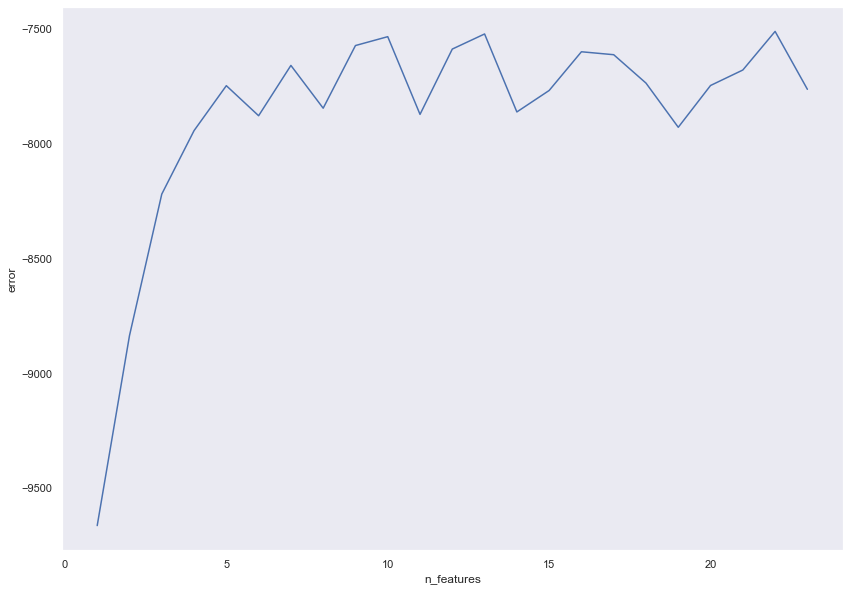

In [107]:
plt.figure()
plt.xlabel('n_features')
plt.ylabel('error')
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

## Select Optimal Features

In [108]:
top_n = 30
# optimal_n_features = min(rfe.grid_scores_.argmax() + 1, top_n)
optimal_n_features = rfe.grid_scores_.argmax() + 1

In [109]:
print(f'The optimal number of features is: {optimal_n_features}')

The optimal number of features is: 22


In [110]:
feature_ranking = pd.Series(rfe.ranking_, index=x_cols)

In [111]:
feature_ranking.sort_values()

primary_size              1
restaurant                1
point_of_interest         1
lodging                   1
home_goods_store          1
health                    1
grocery_or_supermarket    1
furniture_store           1
food                      1
establishment             1
school                    1
store                     1
bar                       1
post_code_place_count     1
mean_post_code_rating     1
med_price_house           1
med_price_apartment       1
construction_year         1
num_bedrooms              1
floor                     1
time_s                    1
car_repair                1
electronics_store         2
dtype: int64

In [112]:
selected_features = list(feature_ranking.sort_values()[:optimal_n_features].index)

In [113]:
selected_features

['primary_size',
 'restaurant',
 'point_of_interest',
 'lodging',
 'home_goods_store',
 'health',
 'grocery_or_supermarket',
 'furniture_store',
 'food',
 'establishment',
 'school',
 'store',
 'bar',
 'post_code_place_count',
 'mean_post_code_rating',
 'med_price_house',
 'med_price_apartment',
 'construction_year',
 'num_bedrooms',
 'floor',
 'time_s',
 'car_repair']

# Fit Model

In [114]:
pipeline.fit(X_train[selected_features], y_train)

Pipeline(memory=None,
         steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('normalize', Normalizer(copy=True, norm='l2')),
                ('estimator',
                 AdaBoostRegressor(base_estimator=None, learning_rate=1.0,
                                   loss='linear', n_estimators=50,
                                   random_state=42))],
         verbose=False)

In [115]:
pred = pipeline.predict(X_test[selected_features])

In [116]:
y_pred = pd.Series(pred, index=y_test.index, name='predicted')

# Draw Learning Curves

In [117]:
learning_curve_res = get_learning_curves(pipeline, X_train[selected_features], y_train, score='neg_median_absolute_error')

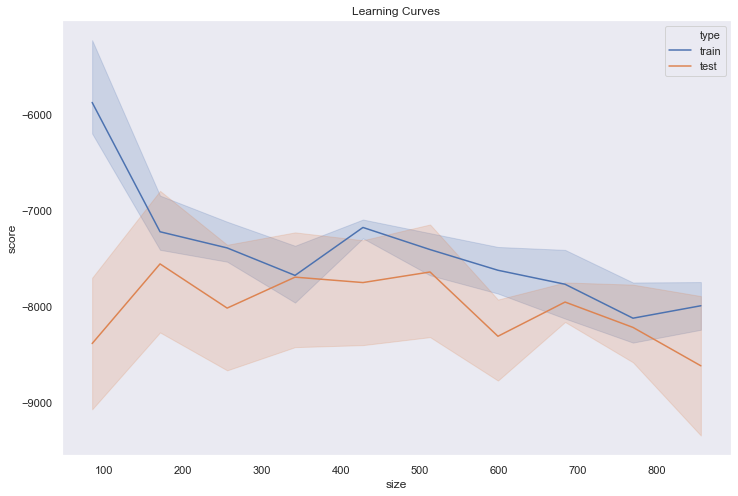

In [118]:
fig = plt.figure(figsize = (12, 8))
plt.title('Learning Curves')
sns.lineplot(x='size', y='score', hue='type', data=learning_curve_res)
plt.show()

# Display Cross-Validation Results

In [119]:
cv_res = get_cv_res(pipeline,
                    X_train[selected_features],
                    y_train,
                    score=['neg_median_absolute_error',
                           'r2',
                           'explained_variance',
                           'max_error'],
                    cv=cv)

In [120]:
print_cv_res(cv_res)

Mean fit_time, 0.13
Mean score_time, 0.02
Mean test_neg_median_absolute_error, -7699.33
Mean test_r2, 0.68
Mean test_explained_variance, 0.69
Mean test_max_error, -78975.36


## Display Predicted VS Actual

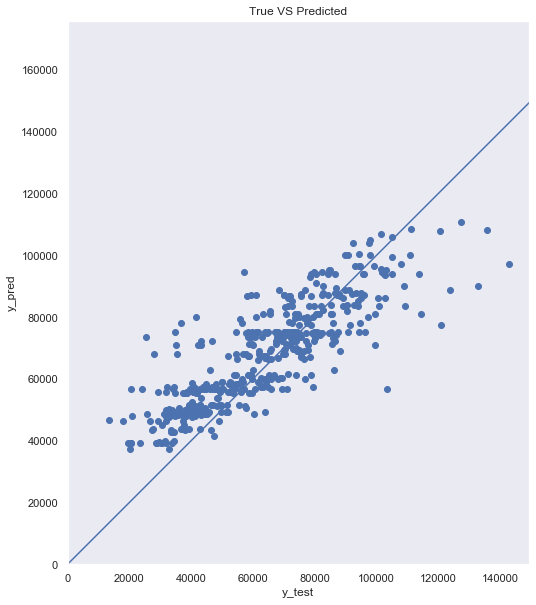

In [121]:
plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-5e7, 5e7], [-5e7, 5e7])
plt.title('True VS Predicted')
plt.show()

## Display Error Spread

In [122]:
to_plot = X_test.join(y_pred).join(y_test)
to_plot['pred_diff'] = to_plot['predicted'] - to_plot[target]

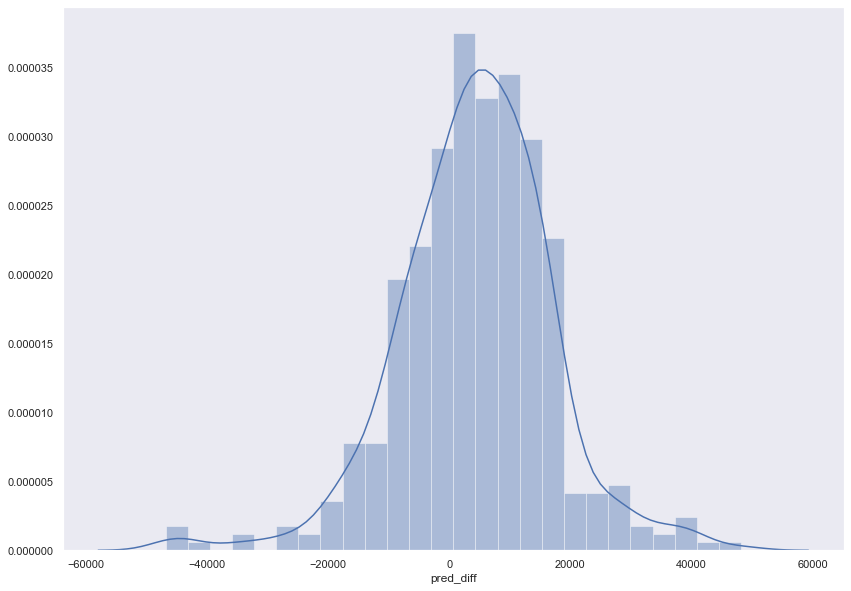

In [123]:
sns.distplot(to_plot.pred_diff)

### Top Overvalued

In [124]:
to_plot[(to_plot.pred_diff > 5e3) | (to_plot.pred_diff < 5e3)].sort_values('pred_diff', ascending=False).head()

,,primary_size,time_s,floor,num_bedrooms,construction_year,med_price_apartment,med_price_house,mean_post_code_rating,post_code_place_count,bar,car_repair,electronics_store,establishment,food,furniture_store,grocery_or_supermarket,health,home_goods_store,lodging,point_of_interest,restaurant,school,store,predicted,price_per_sq_m,pred_diff
ad_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
147039701,3718,79.0,1190.0,2.0,3.0,2011.0,69411.000000,49304.863465,3.45,4.0,1.0,0.0,0.0,12.0,1.0,0.0,0.0,1.0,0.0,0.0,12.0,0.0,1.0,1.0,73618.861538,25410.0,48208.861538
96291081,291,77.0,1047.0,7.0,3.0,2019.0,71483.500000,49304.863465,4.75,2.0,0.0,1.0,1.0,8.0,1.0,0.0,0.0,0.0,2.0,0.0,8.0,1.0,0.0,3.0,78012.266212,36779.0,41233.266212
149813979,4566,124.0,1059.0,1.0,3.0,1984.0,60268.500000,49304.863465,0.00,0.0,5.0,0.0,0.0,16.0,7.0,0.0,0.0,1.0,0.0,6.0,16.0,7.0,0.0,2.0,75301.334507,34903.0,40398.334507
150385208,4931,238.0,1612.0,2.0,6.0,1964.0,73323.344687,65604.500000,4.15,4.0,0.0,0.0,0.0,10.0,1.0,0.0,1.0,1.0,0.0,0.0,10.0,0.0,2.0,1.0,67905.197531,27999.0,39906.197531
149989382,4787,108.0,1354.0,2.0,3.0,1982.0,73323.344687,41542.000000,4.24,5.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,0.0,79873.679181,41542.0,38331.679181


### Top Undervalued

In [125]:
to_plot[(to_plot.pred_diff > 5e3) | (to_plot.pred_diff < 5e3)].sort_values('pred_diff', ascending=False).tail()

,,primary_size,time_s,floor,num_bedrooms,construction_year,med_price_apartment,med_price_house,mean_post_code_rating,post_code_place_count,bar,car_repair,electronics_store,establishment,food,furniture_store,grocery_or_supermarket,health,home_goods_store,lodging,point_of_interest,restaurant,school,store,predicted,price_per_sq_m,pred_diff
ad_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
150667352,5082,64.0,1068.0,7.0,2.0,2005.0,89759.0,49304.863465,3.800000,1.0,1.0,0.0,0.0,14.0,3.0,0.0,1.0,5.0,0.0,1.0,14.0,2.0,1.0,3.0,88621.290640,123821.0,-35199.709360
149581606,4429,85.0,2219.0,4.0,2.0,2017.0,113015.5,93957.000000,4.542857,7.0,0.0,0.0,0.0,10.0,1.0,1.0,1.0,4.0,1.0,0.0,10.0,0.0,0.0,3.0,90111.456140,132746.0,-42634.543860
106352673,605,82.0,1521.0,4.0,2.0,2019.0,72596.0,46875.500000,3.285714,7.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,7.0,0.0,0.0,1.0,77503.332031,120991.0,-43487.667969
150137467,4850,93.0,498.0,7.0,2.0,2010.0,118541.5,49304.863465,4.000000,1.0,2.0,0.0,0.0,16.0,10.0,0.0,0.0,0.0,0.0,4.0,16.0,10.0,0.0,0.0,97024.217573,142826.0,-45801.782427
150048106,4815,119.0,2341.0,2.0,2.0,1930.0,60793.0,103372.000000,3.820000,5.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,1.0,0.0,1.0,9.0,1.0,1.0,2.0,56552.586735,103372.0,-46819.413265


# Display Feature Importances

In [126]:
feature_importances = pd.Series(pipeline.named_steps['estimator'].feature_importances_, index=selected_features).sort_values(ascending=True)

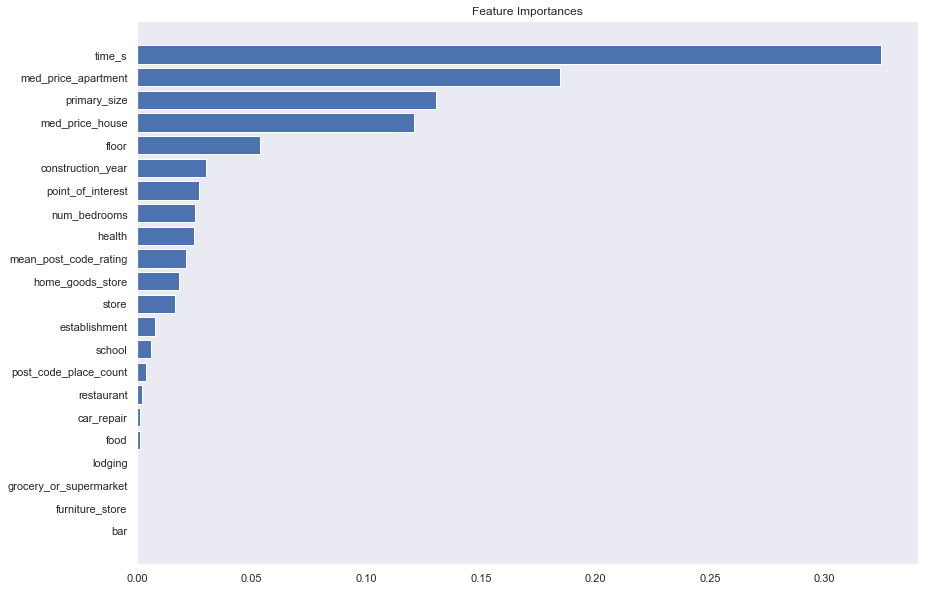

In [127]:
top_n = 30
to_plot = feature_importances[-top_n:]
plt.yticks(range(len(to_plot)), to_plot.index)
plt.title('Feature Importances')
plt.barh(range(len(to_plot)), to_plot)
plt.show()

# Predict Price With NLP

In [128]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [129]:
selected_text_char = 'full_description'

In [130]:
text_data = text_data[text_data.index.isin(model_data.index)].join(model_data[target])

In [131]:
text_data.head()

,,full_description,price_per_sq_m
ad_id,,,
69757913,11,"FremdriftSnr 34,...",39991.0
78653360,14,Om ProsjektetI S...,71210.0
78866228,27,"Sentralt, Lokalt...",71728.0
82173385,41,AdresseRøakollen...,82837.0
84047772,67,AdresseRøakollen...,84843.0


In [132]:
def tokenize_regex(regex, text):
    return [t.lower() for t in re.split(regex, text) if t != '']

In [133]:
def recognize_num(text):
    modified = []
    for t in text:
        try:
            num = int(t)
            modified.append('<num>')
        except ValueError as e:
            modified.append(t)
    return modified

In [134]:
punct_whitesp = re.compile(r'\s|[\+\-\.\,\(\)\?\!]+')

In [135]:
text_data[f'{selected_text_char}_split'] = [tokenize_regex(punct_whitesp, t) for t in text_data[selected_text_char]]
text_data[f'{selected_text_char}_split'] = [recognize_num(text) for text in text_data[f'{selected_text_char}_split']]

In [136]:
text_data.head()

,,full_description,price_per_sq_m,full_description_split
ad_id,,,,
69757913,11,"FremdriftSnr 34,...",39991.0,"[fremdriftsnr, <..."
78653360,14,Om ProsjektetI S...,71210.0,"[om, prosjekteti..."
78866228,27,"Sentralt, Lokalt...",71728.0,"[sentralt, lokal..."
82173385,41,AdresseRøakollen...,82837.0,[adresserøakolle...
84047772,67,AdresseRøakollen...,84843.0,[adresserøakolle...


In [137]:
def dummy_tokenizer(doc):
    return doc

In [138]:
count_vectorizer = CountVectorizer(analyzer='word',
                                   tokenizer=dummy_tokenizer,
                                   preprocessor=dummy_tokenizer,
                                   ngram_range=(1, 1),
                                   token_pattern=None,
                                   min_df=2)

In [139]:
vectorized_full_desc = count_vectorizer.fit_transform(text_data[f'{selected_text_char}_split'])

In [140]:
y_text = text_data.price_per_sq_m

In [141]:
term_index = pd.Series(count_vectorizer.vocabulary_)

In [142]:
term_frequency = pd.Series(vectorized_full_desc.toarray().sum(axis=0), index=term_index.sort_values(ascending=True).index)

In [143]:
stop_word_min_rank = 80

In [144]:
stop_words = list(term_frequency.sort_values(ascending=False)[:stop_word_min_rank].index)

In [145]:
def remove_stop_words(stop_word_list, text):
    return list(set(text) - set(stop_word_list))

In [146]:
text_data[f'{selected_text_char}_split'] = [remove_stop_words(stop_words, text) for text in text_data[f'{selected_text_char}_split']]

In [147]:
vectorized_full_desc = count_vectorizer.fit_transform(text_data[f'{selected_text_char}_split'])

In [148]:
tfidf_transformer = TfidfTransformer()

In [149]:
tfidf = tfidf_transformer.fit_transform(vectorized_full_desc)

In [150]:
tfidf

<1529x12145 sparse matrix of type '<class 'numpy.float64'>'
	with 180467 stored elements in Compressed Sparse Row format>

In [151]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(tfidf,
                                                                        y_text,
                                                                        test_size=test_size,
                                                                        random_state=random_seed)

In [152]:
estimator.fit(X_text_train, y_text_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=42)

In [153]:
y_text_pred = estimator.predict(X_text_test)

# Draw Learning Curves

In [154]:
learning_curve_res = get_learning_curves(estimator,
                                         X_text_train,
                                         y_text_train,
                                         score='neg_median_absolute_error')

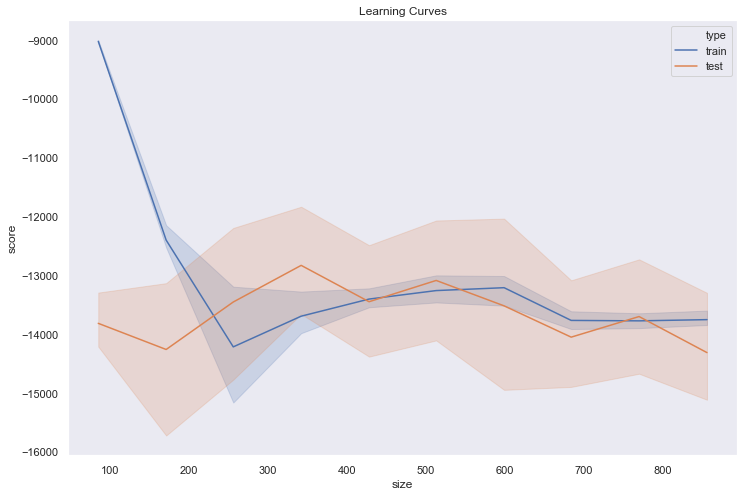

In [155]:
fig = plt.figure(figsize = (12, 8))
plt.title('Learning Curves')
sns.lineplot(x='size', y='score', hue='type', data=learning_curve_res)
plt.show()

# Display Cross-Validation Results

In [156]:
cv_res = get_cv_res(estimator,
                    X_text_train,
                    y_text_train,
                    score=['neg_median_absolute_error',
                           'r2',
                           'explained_variance',
                           'max_error'])

In [157]:
print_cv_res(cv_res)

Mean fit_time, 1.04
Mean score_time, 0.04
Mean test_neg_median_absolute_error, -14316.23
Mean test_r2, 0.31
Mean test_explained_variance, 0.31
Mean test_max_error, -75412.47


In [158]:
feature_importances = pd.Series(estimator.feature_importances_, index=list(count_vectorizer.vocabulary_.keys()))

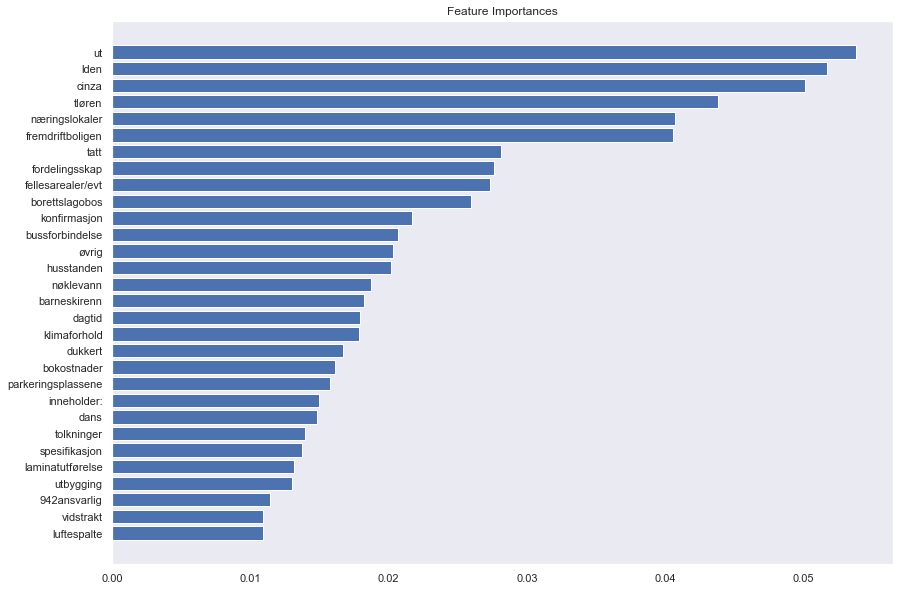

In [159]:
top_n = 30
to_plot = feature_importances.sort_values(ascending=True)[-top_n:]
plt.yticks(range(len(to_plot)), to_plot.index)
plt.title('Feature Importances')
plt.barh(range(len(to_plot)), to_plot)
plt.show()

In [160]:
top_n = 10
best_text_features = list(feature_importances.sort_values(ascending=False)[:top_n].index)

In [161]:
best_text_features

['ut',
 'lden',
 'cinza',
 'tløren',
 'næringslokaler',
 'fremdriftboligen',
 'tatt',
 'fordelingsskap',
 'fellesarealer/evt',
 'borettslagobos']

In [162]:
all_features = X

In [163]:
for f in best_text_features:
    all_features[f] = text_data[selected_text_char].str.lower().str.contains(f).map({True: 1, False: 0})

# Predict Price With All Features

In [164]:
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(all_features,
                                                                        y,
                                                                        test_size=test_size,
                                                                        random_state=random_seed)

In [165]:
pipeline.fit(X_full_train, y_full_train)

Pipeline(memory=None,
         steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('normalize', Normalizer(copy=True, norm='l2')),
                ('estimator',
                 AdaBoostRegressor(base_estimator=None, learning_rate=1.0,
                                   loss='linear', n_estimators=50,
                                   random_state=42))],
         verbose=False)

In [166]:
y_pred = estimator.predict(X_full_test)

# Draw Learning Curves

In [167]:
learning_curve_res = get_learning_curves(pipeline,
                                         X_full_train,
                                         y_full_train,
                                         score='neg_median_absolute_error')

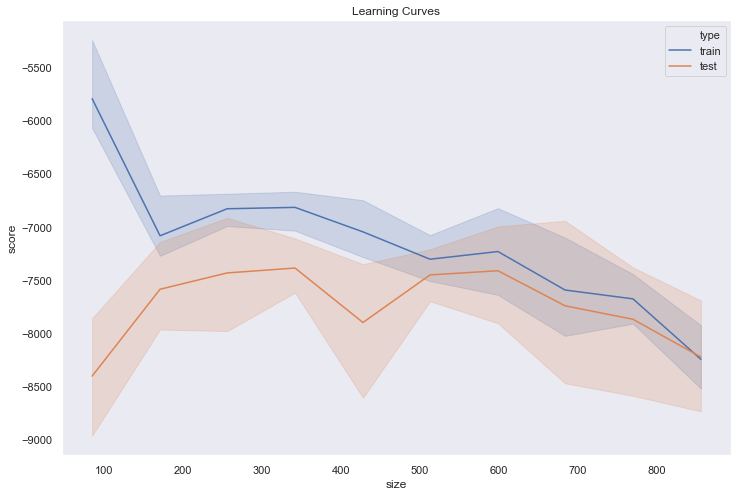

In [168]:
fig = plt.figure(figsize = (12, 8))
plt.title('Learning Curves')
sns.lineplot(x='size', y='score', hue='type', data=learning_curve_res)
plt.show()

# Display Cross-Validation Results

In [169]:
cv_res = get_cv_res(pipeline,
                    X_full_train,
                    y_full_train,
                    score=['neg_median_absolute_error',
                           'r2',
                           'explained_variance',
                           'max_error'])

In [170]:
print_cv_res(cv_res)

Mean fit_time, 0.11
Mean score_time, 0.02
Mean test_neg_median_absolute_error, -8224.54
Mean test_r2, 0.66
Mean test_explained_variance, 0.68
Mean test_max_error, -71807.33


# Display Feature Importances

In [171]:
feature_importances = pd.Series(pipeline.named_steps['estimator'].feature_importances_, index=X.columns).sort_values(ascending=True)

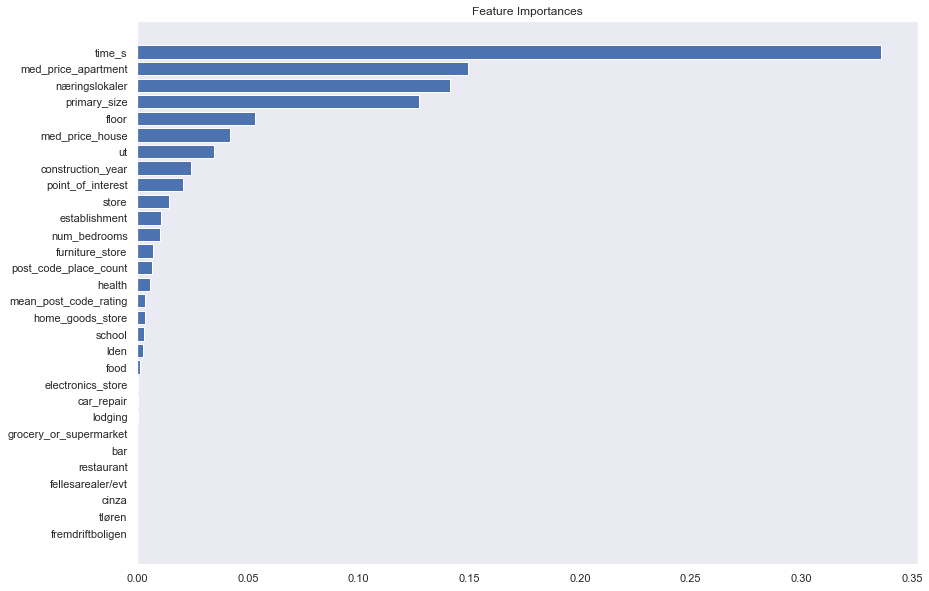

In [172]:
top_n = 30
to_plot = feature_importances[-top_n:]
plt.yticks(range(len(to_plot)), to_plot.index)
plt.title('Feature Importances')
plt.barh(range(len(to_plot)), to_plot)
plt.show()

# TODO
* Draw learning curves on multiple metrics
* Produce statistics for all types of models
* Select final model
* Tune up the final model
* Deploy model to cloud